In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



# Any results you write to the current directory are saved as output.

In [2]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [3]:
# import Dataset in Data Frame
train= pd.read_csv("train.csv")
test = pd.read_csv('test-2.csv')

In [4]:
train.shape
test.shape

(200000, 201)

In [5]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [7]:
#to check for null values
train.isnull().sum()

ID_code    0
target     0
var_0      0
var_1      0
var_2      0
          ..
var_195    0
var_196    0
var_197    0
var_198    0
var_199    0
Length: 202, dtype: int64

In [8]:
#sns.heatmap

In [9]:
# f,ax = plt.subplots(figsize=(3000, 3000))
# sns.heatmap(train.corr(), annot=True, linewidths=.8, fmt= '.3f',ax=ax, cmap="YlGnBu")
# plt.show()

In [10]:
# f,ax = plt.subplots(figsize=(600, 300))
# ax = sns.boxplot(data=train, orient="h", palette="Set2", )

In [38]:
# sns.pairplot(train)
# sns.plt.show()
train.corr()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
target,1.000000,0.052390,0.050343,0.055870,0.011055,0.010915,0.030979,0.066731,-0.003025,0.019584,...,0.055973,0.047114,-0.042858,-0.017709,-0.022838,0.028285,0.023608,-0.035303,-0.053000,0.025434
var_0,0.052390,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,0.006983,0.002429,0.004962,...,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,0.050343,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,0.003258,0.001511,0.004098,...,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.055870,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,0.000883,-0.000991,0.002648,...,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.011055,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-0.000774,0.002500,0.003553,...,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
var_195,0.028285,0.002073,-0.000785,-0.001070,0.001206,0.003706,-0.001274,0.001244,0.001854,0.001396,...,0.004571,0.000870,-0.004745,-0.003143,-0.001201,1.000000,0.002517,-0.004170,-0.000536,0.002042
var_196,0.023608,0.004386,-0.000377,0.003952,-0.002800,0.000513,0.002880,0.005378,0.001045,-0.003242,...,-0.000847,0.002466,-0.001386,-0.005308,-0.005040,0.002517,1.000000,-0.000454,0.000253,0.000607
var_197,-0.035303,-0.000753,-0.004157,0.001078,0.001164,-0.000046,-0.000535,-0.003565,0.003466,-0.004583,...,-0.004974,0.000906,-0.000527,0.005068,0.000884,-0.004170,-0.000454,1.000000,0.001183,0.004991
var_198,-0.053000,-0.005776,-0.004861,-0.000877,-0.001651,-0.001821,-0.000953,-0.003025,0.000650,0.002950,...,-0.000153,-0.000067,0.003451,0.001646,0.003194,-0.000536,0.000253,0.001183,1.000000,-0.004731


In [25]:
#DECISION TREE

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier



In [26]:
# Target variable from the Training Set
Target = train['target']

# Input dataset for Train and Test 
train_inp = train.drop(columns = ['target', 'ID_code'])
test_inp = test.drop(columns = ['ID_code'])

# List of feature names
features = list(train_inp.columns)

In [27]:
# Spliting the Train Dataset into training and validation 

X_train, X_test, Y_train, Y_test = train_test_split(train_inp, Target, 
                                                    test_size= 0.3, random_state = 2000)


In [39]:
# Create Decision Tree Classifier object with few parameters
tree_clf = DecisionTreeClassifier(class_weight='balanced', random_state = 2000, 
                                  max_features = 0.5, min_samples_leaf = 100)

# Fit the model on training data
tree_clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=2000, splitter='best')

In [29]:
# Predict for validation set and check the performance
tree_preds = tree_clf.predict_proba(X_test)[:, 1]
performance(Y_test, tree_preds)

Confusion Matrix:
[[35314 18637]
 [ 2629  3420]]
AUC:
0.6514727493199708


In [34]:
feature_importance_values = tree_clf.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
feature_importances.sort_values(by='importance', ascending=False).head(n=20)

,feature,importance
81,var_81,0.056765
139,var_139,0.049708
12,var_12,0.036840
26,var_26,0.031179
146,var_146,0.028163
110,var_110,0.025983
109,var_109,0.025306
53,var_53,0.025013
6,var_6,0.016548
166,var_166,0.016331


In [31]:
#LightGBM model

import lightgbm as lgb
#Function to build the LightGBM model.
def run_lgb(X_train, Y_train, X_test, Y_test, test_inp):
    params = {
        "objective" : "binary",
        "metric" : "auc",
        "num_leaves" : 1000,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.8,
        "feature_fraction" : 0.8,
        "bagging_freq" : 5,
        "reg_alpha" : 1.728910519108444,
        "reg_lambda" : 4.9847051755586085,
        "random_state" : 42,
        "bagging_seed" : 2019,
        "verbosity" : -1,
        "max_depth": 18,
        "min_child_samples":100
       # ,"boosting":"rf"
    }
    
    lgtrain = lgb.Dataset(X_train, label=Y_train)
    lgval = lgb.Dataset(X_test, label=Y_test)
    evals_result = {}
    model = lgb.train(params, lgtrain, 2500, valid_sets=[lgval], 
                      early_stopping_rounds=35, verbose_eval=50, evals_result=evals_result)
    
    pred_test_y = model.predict(test_inp, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

# Training the model #
pred_test, model, evals_result = run_lgb(X_train, Y_train, X_test, Y_test, test_inp)

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.791309
[100]	valid_0's auc: 0.814617
[150]	valid_0's auc: 0.832517
[200]	valid_0's auc: 0.844464
[250]	valid_0's auc: 0.852515
[300]	valid_0's auc: 0.858544
[350]	valid_0's auc: 0.863351
[400]	valid_0's auc: 0.867375
[450]	valid_0's auc: 0.870693
[500]	valid_0's auc: 0.873406
[550]	valid_0's auc: 0.875718
[600]	valid_0's auc: 0.877664
[650]	valid_0's auc: 0.879197
[700]	valid_0's auc: 0.880606
[750]	valid_0's auc: 0.881624
[800]	valid_0's auc: 0.882645
[850]	valid_0's auc: 0.883425
[900]	valid_0's auc: 0.884172
[950]	valid_0's auc: 0.884776
[1000]	valid_0's auc: 0.885414
[1050]	valid_0's auc: 0.885882
[1100]	valid_0's auc: 0.886246
[1150]	valid_0's auc: 0.886609
[1200]	valid_0's auc: 0.887012
[1250]	valid_0's auc: 0.887411
[1300]	valid_0's auc: 0.887656
[1350]	valid_0's auc: 0.887936
[1400]	valid_0's auc: 0.888277
[1450]	valid_0's auc: 0.888519
[1500]	valid_0's auc: 0.888737
[1550]	valid_0's auc: 0.88888

In [32]:
# Feature Extraction & importance
feature_importance_values = model.feature_importance()
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
feature_importances.sort_values(by='importance', ascending=False).head(n=20)

,feature,importance
34,var_34,7953
1,var_1,7838
6,var_6,7767
21,var_21,7734
53,var_53,7692
146,var_146,7669
76,var_76,7621
22,var_22,7590
190,var_190,7559
192,var_192,7552


In [41]:
feature_importances_df = pd.DataFrame(feature_importances)

In [33]:
# Submission dataframe
pred_test[pred_test>1] = 1
pred_test[pred_test<0] = 0

submitLGB = test[['ID_code']]
submitLGB["target"] = pred_test

# Creating the Submission for Light GBM
submitLGB.to_csv('LightGBM.csv', index = False)

submitLGB

,ID_code,target
0,test_0,0.122637
1,test_1,0.072305
2,test_2,0.098413
3,test_3,0.051596
4,test_4,0.015557
...,...,...
199995,test_199995,0.006772
199996,test_199996,0.003121
199997,test_199997,0.001441
199998,test_199998,0.038233


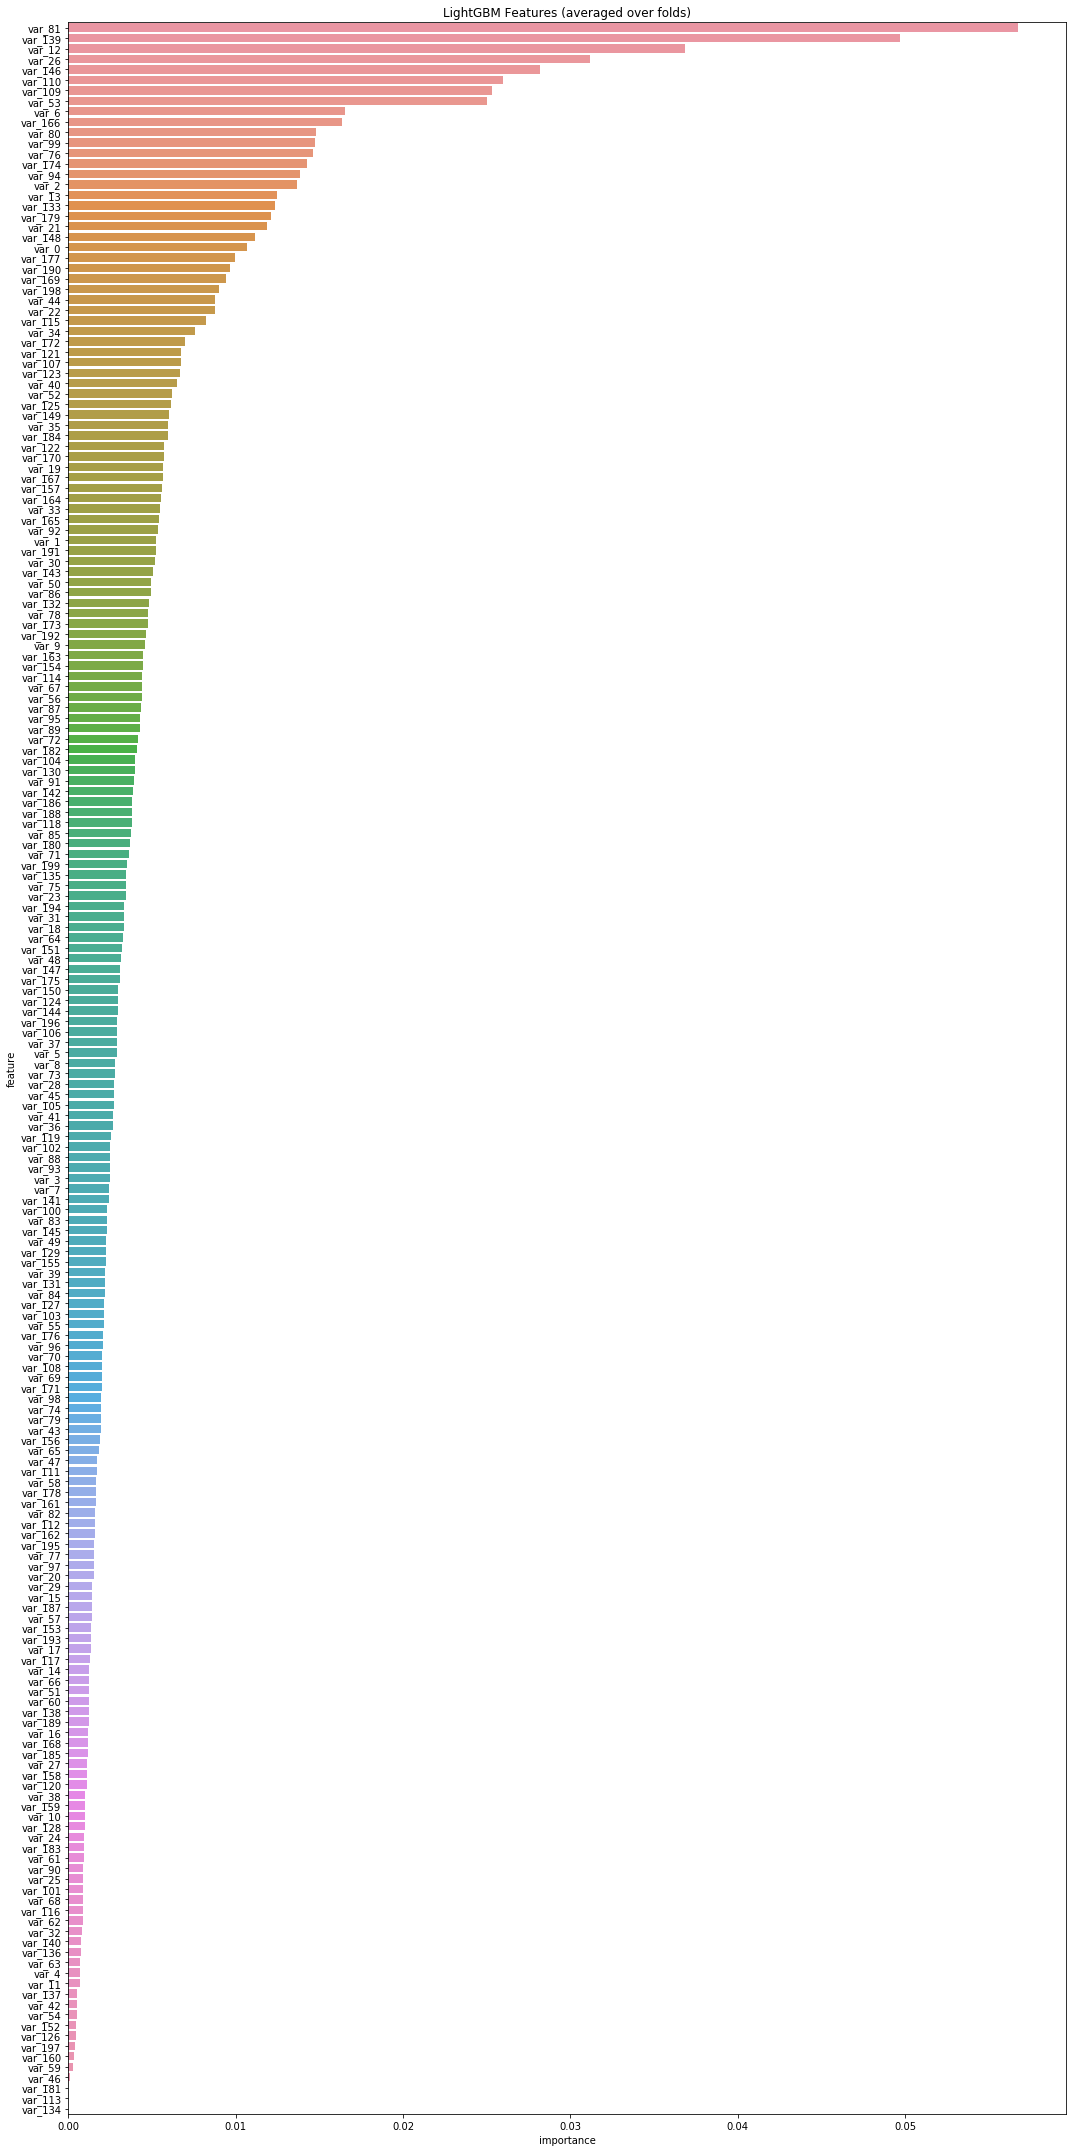

In [42]:
cols = (feature_importances_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importances_df.loc[feature_importances_df.feature.isin(cols)]

plt.figure(figsize=(15,30))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
# We notice both the models gives different results for feature imortance, so we need to work more on this.
#next update will be uploaded soon.